In [59]:
import prometheus_pandas.ipython.magic
from prometheus_pandas import query
from matplotlib import pyplot as plt
import pandas as pd

In [60]:
#%%prometheus_query http://localhost:9090 
#    prom_histogram_bucket

In [61]:
p = query.Prometheus('http://localhost:9090')

In [62]:
p.query('prom_histogram_bucket')

prom_histogram_bucket{instance="host.docker.internal:9184",job="HistogramTest",le="+Inf"}    31271.0
prom_histogram_bucket{instance="host.docker.internal:9184",job="HistogramTest",le="1"}        6222.0
prom_histogram_bucket{instance="host.docker.internal:9184",job="HistogramTest",le="2"}       12519.0
prom_histogram_bucket{instance="host.docker.internal:9184",job="HistogramTest",le="3"}       18819.0
prom_histogram_bucket{instance="host.docker.internal:9184",job="HistogramTest",le="4"}       25033.0
prom_histogram_bucket{instance="host.docker.internal:9184",job="HistogramTest",le="5"}       31271.0
dtype: float64

In [63]:
df = p.query('prom_histogram_bucket[1m]')
df

,"prom_histogram_bucket{instance=""host.docker.internal:9184"",job=""HistogramTest"",le=""+Inf""}","prom_histogram_bucket{instance=""host.docker.internal:9184"",job=""HistogramTest"",le=""1""}","prom_histogram_bucket{instance=""host.docker.internal:9184"",job=""HistogramTest"",le=""2""}","prom_histogram_bucket{instance=""host.docker.internal:9184"",job=""HistogramTest"",le=""3""}","prom_histogram_bucket{instance=""host.docker.internal:9184"",job=""HistogramTest"",le=""4""}","prom_histogram_bucket{instance=""host.docker.internal:9184"",job=""HistogramTest"",le=""5""}"
2023-06-26 09:52:52.865999937,31162.0,6203.0,12473.0,18755.0,24948.0,31162.0
2023-06-26 09:52:57.865000010,31172.0,6205.0,12475.0,18760.0,24955.0,31172.0
2023-06-26 09:53:02.865000010,31182.0,6209.0,12480.0,18767.0,24964.0,31182.0
2023-06-26 09:53:07.865999937,31192.0,6209.0,12484.0,18773.0,24972.0,31192.0
2023-06-26 09:53:12.865999937,31202.0,6211.0,12489.0,18779.0,24981.0,31202.0
2023-06-26 09:53:17.865999937,31212.0,6213.0,12493.0,18786.0,24988.0,31212.0
2023-06-26 09:53:22.865000010,31222.0,6213.0,12496.0,18790.0,24993.0,31222.0
2023-06-26 09:53:27.865999937,31231.0,6216.0,12501.0,18797.0,25001.0,31231.0
2023-06-26 09:53:32.865000010,31241.0,6219.0,12505.0,18801.0,25008.0,31241.0
2023-06-26 09:53:37.865999937,31251.0,6219.0,12511.0,18809.0,25018.0,31251.0


In [64]:
lastMinute = p.query('increase(prom_histogram_bucket[1m])')
lastMinute

{instance="host.docker.internal:9184",job="HistogramTest",le="+Inf"}    118.911253
{instance="host.docker.internal:9184",job="HistogramTest",le="1"}        20.727650
{instance="host.docker.internal:9184",job="HistogramTest",le="2"}        50.182731
{instance="host.docker.internal:9184",job="HistogramTest",le="3"}        69.819451
{instance="host.docker.internal:9184",job="HistogramTest",le="4"}        92.728959
{instance="host.docker.internal:9184",job="HistogramTest",le="5"}       118.911253
dtype: float64

Funktionen increase ser på ændringen over det angivne tidsinterval. Kan vi fx selv regne det i hånden?

In [65]:
df.iloc[11][2] -  df.iloc[0][2]

46.0

Det passer jo ikke? Tidsintervallet er angivet til 1m. Lad os kigge på nærmere på observationerne.

In [75]:
46/55 * 60

50.18181818181818

In [66]:
lastMinute = p.query('sum(increase(prom_histogram_bucket[1m])) by (le)')
lastMinute

{le="+Inf"}    118.911253
{le="1"}        20.727650
{le="2"}        50.182731
{le="3"}        69.819451
{le="4"}        92.728959
{le="5"}       118.911253
dtype: float64

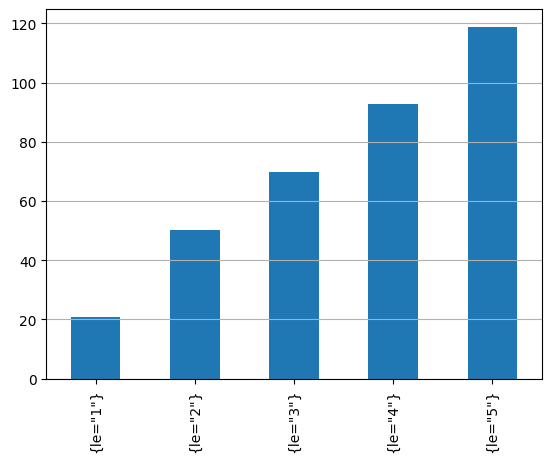

In [67]:
hist = lastMinute[1:].plot(kind='bar')
_ = hist.grid(axis='y');

In [68]:
p.query('histogram_quantile(0.95, increase(prom_histogram_bucket[1m]))') 

{instance="host.docker.internal:9184",job="HistogramTest"}    4.772917
dtype: float64

In [69]:
p.query('histogram_quantile(0.95, sum(increase(prom_histogram_bucket[1m])) by (le))') 

{}    4.772917
dtype: float64

Vi har i alt

lastMinute['{le="5"}']

20 

observationer. 95% fraktil svarer til

In [70]:
0.95 * lastMinute['{le="5"}']

112.9656902852779

Hvilket er et antal observationer inde i bucket 5:

In [71]:
target = 0.95 * lastMinute['{le="5"}'] - lastMinute['{le="4"}']
target

20.236731576937743

Lad os antage, at de observationer som falder i bucket 5 er fordelt ligeligt over bucket 5, så kan vi udregne en hældning:

In [72]:
slope = 1.0 / (lastMinute['{le="5"}'] - lastMinute['{le="4"}'])
slope 

0.03819375000000001

Hvilket bucket indeholder ovenstående request? Det gør bucket 5.

In [73]:
4.0 + slope * target

4.772916666666666

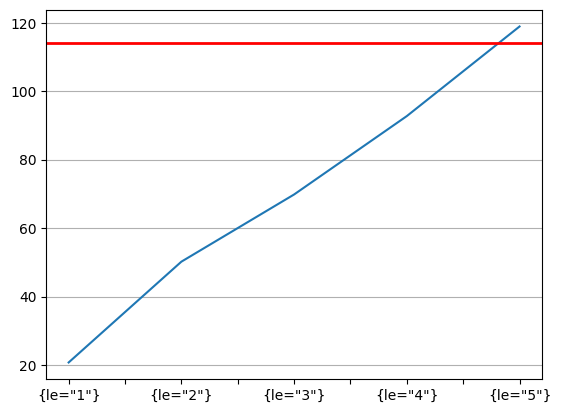

In [74]:
plot = lastMinute[1:].plot(kind='line');
plot.grid(axis='y');
_  = plot.axhline(y=0.95*120, color= 'red', linewidth=2,)